## Imports and global settings

In [1]:
from __future__ import absolute_import, division, print_function

import os
import numpy as np
import datetime
import gc
import h5py
import json
from keras.models import Sequential, Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Dense
from keras.layers import Lambda, Dropout, Flatten, Input, BatchNormalization
from keras.optimizers import Adam, Nadam, Adamax, Adadelta, Adagrad, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1, l1l2, l2

import sys
# Add the parent folder path to the sys.path list
sys.path.append('../')
import utils
reload(utils)
from utils import plots, remove_chars_re, plot_files, plot_images, load_array, save_array

from IPython.display import FileLink
from IPython.core.debugger import Tracer

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
path = './'
batch_size = 128
image_size = (224, 224)
weights_file = 'vgg16_bn.h5'  # 'checkpoint-14.2-15.4.18-00-0.0883.hdf5'

## Load the data

#### Create a keras data generator, that flows the images from the specified dir.

In [3]:
def get_batch(path, batch_size, shuffle=True, augument=False,
              class_mode='categorical', fill_mode='constant'):
    if augument:
        data_generator = ImageDataGenerator(
            #             rotation_range=40,
            #             width_shift_range=0.2,
            #             height_shift_range=0.2,
            #             zoom_range=0.2,
            #             shear_range=0.2,
            #             horizontal_flip=True,
            #             fill_mode='nearest'
            rotation_range=40,  # Possibly 20
            width_shift_range=0.3,
            height_shift_range=0.3,
            zoom_range=0.4,
            channel_shift_range=30,
            shear_range=0.5,
            horizontal_flip=True,
            fill_mode=fill_mode
        )
    else:
        data_generator = ImageDataGenerator()
    return data_generator.flow_from_directory(directory=path,
                                              batch_size=batch_size,
                                              target_size=image_size,
                                              shuffle=shuffle,
                                              class_mode=class_mode)

#### Load all sets.

In [4]:
train = get_batch(os.path.join(path, 'train/'),
                  augument=False, batch_size=batch_size)
valid = get_batch(os.path.join(path, 'valid/'), batch_size=batch_size)
test = get_batch(os.path.join(path, 'test/'),
                 batch_size=batch_size,
                 shuffle=False,
                 class_mode=None)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


#### Preview data augumentation

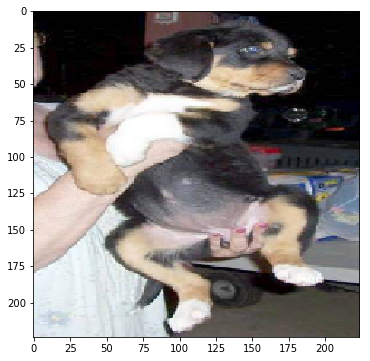

In [6]:
# Get an image to play with
image = next(valid)[0][0:1]
plots(image)

In [ ]:
# try augumentation on this image
data_generator = ImageDataGenerator(
    rotation_range=40,  # Possibly 20
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.4,
    channel_shift_range=30,
    shear_range=0.5,
    horizontal_flip=True,
    fill_mode='constant'
)
images_generator = data_generator.flow(image)
augumented_images = [next(images_generator)[0] for i in range(32)]
plot_images(augumented_images, images_per_row=4)

## Define VGG model.

Define a convolutional layer

In [5]:
def convolution(model, layers, filters):
    for layer_index in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    return model

Preprocessing the image: Sub imagenet mean values; Flip channels from RGB to BGR.

In [6]:
def preprocess(image):
    # input is shaped (batch_size, channels, width, height)
    imagenet_means = np.asarray([123.68, 116.779, 103.939]).reshape([3, 1, 1])
    image -= imagenet_means
    # Flip the channels
    return image[:, ::-1, :, :]

Define the model, according to the VGG paper.

In [7]:
def vgg16_model():
    model = Sequential()
    model.add(Lambda(preprocess, input_shape=(3, 224, 224)))
    model = convolution(model, 2, 64)
    model = convolution(model, 2, 128)
    model = convolution(model, 3, 256)
    model = convolution(model, 3, 512)
    model = convolution(model, 3, 512)
    model.add(Flatten())

    # Dense 1
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Dense 2
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # Softmax output
    model.add(Dense(1000, activation='softmax'))
    return model

model = vgg16_model()

Create unique model name (from the model layers)

In [8]:
def get_model_name(model):
    '''Create a model name in the form:
        3xC64-1xC128-2xD4096-Drop0.5-BN 
        from model:
        Convolution2D(64)
        Convolution2D(64)
        Convolution2D(64)
        Convolution2D(128)
        Dense(4096)
        Dropout(0.5)
        BatchNormalization()
        Dense(4096)
        Dropout(0.5)

    '''
    model_name = ''
    repeating_layers_count = 1
    prev_layer_code = False
    dropout = 0
    batch_norm = False
    # Get the model config as json
    data = json.loads(model.to_json())
    for layer in data['config']:
        layer_code = False
        if layer['class_name'] == 'Convolution2D':
            # Detect Convolution layers
            layer_code = "C{}".format(layer['config']['nb_filter'])
        elif layer['class_name'] == 'Dense':
            # Detect Dense layers
            layer_code = "D{}".format(layer['config']['output_dim'])
        elif layer['class_name'] == 'Dropout':
            dropout = layer['config']['p']
        elif layer['class_name'] == 'BatchNormalization':
            batch_norm = True

        if not layer_code:
            # Not Dense or conv layer, so dont compare with previous
            # dense or conv.
            continue

        # If there were previous layers
        if prev_layer_code:
            # Was the previous layer was the same as the current one?
            # (and this is not the first layer).
            if prev_layer_code == layer_code:
                # We are seeing repeating layers
                repeating_layers_count += 1
            else:
                # Not the same as the previous one
                # Add the prev layer(s) to the model desc
                # NB: Because we only add the layer after we have seen a diff
                # dense or conv one will miss the last layer in the model,
                # which is OK since it's the output layer anyway.
                model_name += ('{}x{}-').format(
                    repeating_layers_count,
                    prev_layer_code)
                repeating_layers_count = 1
        # The current layer will be the prev one in the next iteration
        prev_layer_code = layer_code

    # Add information about BN and dropout
    model_name += 'Drop{}'.format(dropout)
    if batch_norm:
        model_name += '-BN'
    return model_name


def create_dir(name):
    ''' Create a dir if not exists.
    '''
    if not os.path.exists(name):
        os.makedirs(name)


def save_architecture(model, model_name):
    '''Save the architecture of the model to a file named
        model_name.
    '''
    model_json = model.to_json()
    # Save in the dir name after the model
    filepath = os.path.join(model_name, model_name + '.json')
    with open(filepath, 'w') as f:
        f.write(model_json)


def get_name_and_save_model(model):
    '''Get the model name and save the model.
    Args:
        model: The keras model
    Returns: 
        The model name
    '''
    model_name = get_model_name(model)
    create_dir(model_name)
    save_architecture(model, model_name)
    return model_name

Display what is in the weights file

In [9]:
def get_weight_layers(weights_file):
    # To load the weights for the dense layers,
    # we need to set the layers' names to be the same
    # as in the saved weights file.
    f = h5py.File(weights_file, mode='r')
    return [n.decode('utf8') for n in f.attrs['layer_names']]

# get_weight_layers(weights_file)

Load the precomputed Imagenet weights.

In [ ]:
def vgg_load_weights(model, weights_file):
    # If file exists in current dir (keras get_file doesn't check current dir)
    if os.path.exists(weights_file):
        weights = weights_file
    elif os.path.exists(os.path.join('models', weights_file)):
        # ./models/weights_file
        weights = os.path.join('models', weights_file)
    elif os.path.exists(os.path.join('../', 'models', weights_file)):
        # ../models/weights_file
        weights = os.path.join('../', 'models', weights_file)
    else:
        # Get file uses downloaded weights (in keras cache)
        # or downloads them if not present.
        path = 'http://www.platform.ai/models/'
        weights_file = 'vgg16_bn.h5'
        weights = get_file(weights_file, path + weights_file,
                           cache_subdir='models')
    model.load_weights(weights)
    return model
# print(weights_file)
model = vgg_load_weights(model, weights_file=weights_file)

Finally, compile and the model is ready to use.

In [ ]:
def model_compile(model, optimizer=None, learning_rate=None):
    if not optimizer:
        optimizer = Adam()
    if learning_rate:
        optimizer.lr.set_value(learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

model = model_compile(model)
model_name = get_name_and_save_model(model)

Decode the ids of the 1000 classes in the Imagenet competition for humans.

In [12]:
def setup_imagenet_id_to_class():
    path = 'http://www.platform.ai/models/'
    class_mappings_filename = 'imagenet_class_index.json'
    mappings_file = get_file(class_mappings_filename, path +
                             class_mappings_filename, cache_subdir='models')
    with open(mappings_file, 'r') as f:
        mappings = json.load(f)

    return mappings
# Read the mappings from class id to class name
mappings = setup_imagenet_id_to_class()


def imagenet_id_to_class(id):
    '''A convenience function to extract the class name
    '''
    return mappings[str(id)][1]

Predict some images

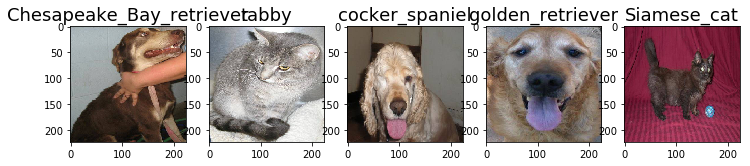

In [14]:
batch = train.next()
images = batch[0][0:5]
predictions = model.predict(images)
predictions_class_ids = np.argmax(predictions, axis=1)
predicted_classes = [imagenet_id_to_class(id) for id in predictions_class_ids]
plots(images, titles=predicted_classes)

## Finetune last layer(s) using full network

Pop the 1000 classes last layer off our model, and replace it with a 2 class (dog, cat).

In [ ]:
def vgg_finetune(model):
    # Freeze the original model
    for layer in model.layers:
        layer.trainable = False
    # Replace the last layer
    model.pop()
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', name='dense_2_softmax'))
    return model

model = vgg_finetune(model)
# weights_file = ("2xC64-2xC128-3xC256-6xC512-2xD4096-Drop0.5-BN/" +
#                 "22.2-14.39.33-00-0.0830.hdf5")
# model.load_weights(weights_file)

In [18]:
model = model_compile(model, optimizer=Adam())  # Adadelta, RMSprop
model_name = get_name_and_save_model(model)

In [15]:
def get_checkpoint(model_name, period=1):
    now = datetime.datetime.now()
    date_string = "{0}.{1}-{2}.{3}.{4}".format(
        now.day, now.month, now.hour, now.minute, now.second)
    filepath = os.path.join(
        model_name,
        date_string + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    return ModelCheckpoint(filepath, save_weights_only=True,
                           period=period, save_best_only=True)

In [20]:
checkpoint = get_checkpoint(model_name, period=1)

Finetune the new output layer.

In [22]:
# Use 1/10th of the train set for an epoch. Otherwise keras/theano
# mysteriously hangs when training is complete
train_per_epoch = 0.5
samples_per_epoch = int(
    ((train.nb_sample * train_per_epoch) // batch_size) * batch_size)
model.fit_generator(train, samples_per_epoch=samples_per_epoch,
                    nb_epoch=int(1 / train_per_epoch),
                    validation_data=valid, nb_val_samples=valid.nb_sample,
                    callbacks=[checkpoint])

Epoch 1/2
11392/11392 [==============================] - 621s - loss: 0.1683 - acc: 0.9697 - val_loss: 0.0725 - val_acc: 0.9810

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


11480/11392 [==============================] - 509s - loss: 0.1021 - acc: 0.9713 - val_loss: 0.0729 - val_acc: 0.9815


In [26]:
model.save('vgg16_noAug_Drop0.5_BN_0.0879')

In [23]:
model.optimizer.lr = 1e-4
# Use only a part of the train set for an epoch. Otherwise keras/theano
# mysteriously hangs when training is complete
train_per_epoch = 0.5
samples_per_epoch = int(
    ((train.nb_sample * train_per_epoch) // batch_size) * batch_size)
model.fit_generator(train, samples_per_epoch=samples_per_epoch,
                    nb_epoch=int(1 / train_per_epoch),
                    validation_data=valid, nb_val_samples=valid.nb_sample,
                    callbacks=[checkpoint])

Epoch 1/2
11392/11392 [==============================] - 353s - loss: 0.0698 - acc: 0.9764 - val_loss: 0.0605 - val_acc: 0.9805

In [51]:
model.load_weights('2xC64-2xC128-3xC256-6xC512-3xD4096-Drop0.5-BN/' +
                   '23.2-13.50.31-01-0.0492.hdf5')

In [53]:
model.optimizer.lr = 1e-6
# Use only a part of the train set for an epoch. Otherwise keras/theano
# mysteriously hangs when training is complete
train_per_epoch = 0.5
samples_per_epoch = int(
    ((train.nb_sample * train_per_epoch) // batch_size) * batch_size)
model.fit_generator(train, samples_per_epoch=samples_per_epoch,
                    nb_epoch=int(1 / train_per_epoch),
                    validation_data=valid, nb_val_samples=valid.nb_sample,
                    callbacks=[checkpoint])

Epoch 1/2
11392/11392 [==============================] - 372s - loss: 0.0628 - acc: 0.9781 - val_loss: 0.0445 - val_acc: 0.9840

In [54]:
model.optimizer.lr = 1e-7
# Use only a part of the train set for an epoch. Otherwise keras/theano
# mysteriously hangs when training is complete
model.fit_generator(train, samples_per_epoch=train.nb_sample,
                    nb_epoch=1,
                    validation_data=valid, nb_val_samples=valid.nb_sample,
                    callbacks=[checkpoint])

Epoch 1/1
23000/23000 [==============================] - 665s - loss: 0.0566 - acc: 0.9798 - val_loss: 0.0547 - val_acc: 0.9790

In [ ]:
model.save(model_name + '/vgg16_3x4096_noAug_Drop0.5_BN_0.0547')

## Extract features (embeddings) 

### Setup extract features model

In [58]:
# Review the model to pick a layer to extract features
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

Use the last max pool layer.

In [ ]:
def get_last_layer(model, layer_type):
    '''Returns the last layer of type `layer_type` in `model`.
    '''
    # Traverse from the end, but keeping the original indexes.
    for original_index, layer in reversed(list(enumerate(model.layers))):
        # Found the last layer of this type
        if type(layer) == layer_type:
            return layer, original_index

features_layer, features_layer_index = get_last_layer(model, Flatten)
# features_layer = model.get_layer(name="flatten_1")
features_layer.name, features_layer_index

In [62]:
# Model to extract the features
features_extract_model = Model(input=model.input,
                               output=features_layer.output)

### Compute features/embeddings

In [26]:
# Get train, valid and test data without augumentation
train = get_batch(os.path.join(path, 'train/'),
                  batch_size=batch_size,
                  augument=False,
                  shuffle=False,
                  )
train_labels = to_categorical(train.classes, nb_classes=train.nb_class)
train_filenames = train.filenames
valid = get_batch(os.path.join(path, 'valid/'),
                  batch_size=batch_size,
                  augument=False,
                  shuffle=False
                  )
valid_labels = to_categorical(valid.classes, nb_classes=valid.nb_class)
valid_filenames = valid.filenames
test = get_batch(os.path.join(path, 'test/'),
                 batch_size=batch_size,
                 augument=False,
                 shuffle=False,
                 class_mode=None)
test_filenames = test.filenames

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


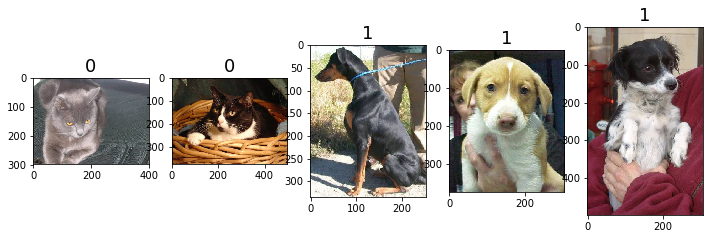

In [64]:
# Sanity check some labels
start = 998
end = 1003
files = [os.path.join(path, 'valid/', filename)
         for filename in valid.filenames[start:end]]
plot_files(files, titles=valid.classes[start:end])

#### Validation set features

In [ ]:
# Extract the valid features
valid_features = features_extract_model.predict_generator(
    che, val_samples=valid.nb_sample)
save_array('valid_features_vgg16.bc', valid_features)
save_array('valid_labels.bc', valid_labels)
save_array('valid_filenames.bc', valid_filenames)

#### Train set features

In [58]:
# Extract the train features
repeat_train_set_n = 1
filename_postfix = 'no_aug'
# train_features = features_extract_model.predict_generator(
#     train, val_samples=train.nb_sample * repeat_train_set_n)
# # Save the computed features
features_filename = 'train_features_{}x_{}.bc'.format(repeat_train_set_n,
                                                      filename_postfix)
save_array(features_filename, train_features)
# Save the labels and the filenames for the computed features
labels_filename = 'train_labels_{}x.bc'.format(repeat_train_set_n,
                                               filename_postfix)
names_filename = 'train_filenames_{}x.bc'.format(repeat_train_set_n,
                                                 filename_postfix)

if repeat_train_set_n == 1:
    save_array(labels_filename, train_labels)
    save_array(names_filename, train_filenames)
else:
    # Also need to repeat the train set
    labels_extended = np.asarray(list(train_labels) * repeat_train_set_n)
    filenames_extended = np.asarray(list(train_filenames) * repeat_train_set_n)
    save_array(labels_filename, labels_extended)
    save_array(names_filename, filenames_extended)

#### Test set features

In [ ]:
# Extract the test features
test_features = features_extract_model.predict_generator(
    test, val_samples=test.nb_sample)
save_array('test_features_vgg16.bc', test_features)
save_array('test_filenames.bc', test_filenames)

#### Load precomputed data

In [66]:
# Load train features (if we didnt just compute them)
train_features = load_array('train_features_1x_no_aug.bc')
train_labels = load_array('train_labels_1x.bc')
train_filenames = load_array('train_filenames_1x.bc')

train_features.shape, train_labels.shape, train_filenames.shape

((23000, 25088), (23000, 2), (23000,))

In [67]:
# Load valid features (if we didnt just compute them)
valid_features = load_array('valid_features_vgg16.bc')
valid_labels = load_array('valid_labels.bc')
valid_filenames = load_array('valid_filenames.bc')
valid_features.shape, valid_labels.shape, valid_filenames.shape

((2000, 25088), (2000, 2), (2000,))

In [68]:
# Load test features (if we didnt just compute them)
test_features = load_array('test_features_vgg16.bc')
test_filenames = load_array('test_filenames.bc')
test_features.shape, test_filenames.shape

((12500, 25088), (12500,))

## Finetune with precomputed features

#### Create and setup the model

In [16]:
def setup_model_features(input_shape, dropout=0.5, batch_norm=False):
    '''Setup the faster model.
    '''
    # Use the layer names from the saved weights file.
    model = Sequential()
    # Dense 1
    model.add(Dense(4096, activation='relu', init="he_normal",
                    name='dense_1', input_shape=input_shape))
    if batch_norm:
        model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(dropout))

    # Dense 2
    model.add(Dense(4096, activation='relu', init="he_normal",
                    name='dense_2'))
    if batch_norm:
        model.add(BatchNormalization(name='batchnorm_2'))
    model.add(Dropout(dropout))

    # Dense 3
    model.add(Dense(4096, activation='relu', init="he_normal",
                    name='dense_new_3'))
    if batch_norm:
        model.add(BatchNormalization(name='batchnorm_3'))
    model.add(Dropout(dropout))

    # Output
    model.add(Dense(2, activation='softmax', name='dense_new_4'))
    return model


def change_dropout(model, previous_dropout, new_dropout):
    ''' Adjust the weights of the layers for new dropout probality.
    '''
    weight_scale = (1 - previous_dropout) / (1 - new_dropout)
    for layer_index, layer in enumerate(model.layers):
        if type(layer) is Dropout:
            # Find the previous Dense or Convolution2d layers and resize their
            # weights
            before_dropout_layers = model.layers[:layer_index]
            # We want to start with the nearest layers first
            for prev_layer in before_dropout_layers[::-1]:
                if (type(prev_layer) is Convolution2D or
                        type(prev_layer) is Dense):
                    # Found the layer to resize weights.
                    weights = prev_layer.get_weights()
                    # Weights include both weights and bias

                    new_weights = [w * weight_scale for w in weights]
                    # Set the new weights
                    prev_layer.set_weights(new_weights)
                    # We do this only for the first layer before the dropout
                    break
    return model


def create_model(dropout=0.5, batch_norm=False, learning_rate=None,
                 weights_file=None, save_period=1):
    dropout = dropout
    # Input is 512 * 7 * 7 vector
    model = setup_model_features(input_shape=(25088,),
                                 dropout=dropout,
                                 batch_norm=batch_norm)
    if weights_file:
        # Load the weights for current layers only. This works because we named
        # them the same way as in the weights file.
        model.load_weights(weights_file, by_name=True)

    # Change Dropout amount
    previous_dropout = 0.5  # This is the dropout from the weights file
    model = change_dropout(
        model,
        previous_dropout=previous_dropout,
        new_dropout=dropout)

    model.name = get_name_and_save_model(model)
    checkpoint = get_checkpoint(model_name=model.name, period=save_period)

    model = model_compile(model, learning_rate=learning_rate)
    return model, checkpoint

In [145]:
%xdel model_fast
for i in range(3):
    gc.collect()

batch_size = 1024
dropout = 0.5
# weights_file = 'VGG16-3x4096-Drop0.5-BN-0.0481.hdf5'
# weights_file = 'VGG16-3x4096-Drop0.5-NoBN-21.2-18.41.32-03-0.0408.hdf5'
weights_file = None
model_fast, checkpoint = create_model(
    dropout=dropout,
    batch_norm=True,
    learning_rate=1e-5,
    weights_file=weights_file,
    save_period=1)

NameError: name 'model_fast' is not defined


#### Load the weights (from the full model)

In [ ]:
weights_file = ('2xC64-2xC128-3xC256-6xC512-3xD4096-Drop0.5-BN/'
                + '23.2-13.50.31-00-0.0445.hdf5')
# get_weight_layers(weights_file)

In [ ]:
# Load a VGG16 model to load weights from
model_vgg = vgg16_model()
model_vgg = vgg_finetune(model_vgg)
model_vgg = vgg_load_weights(model_vgg, weights_file)

Get the fc layers of model_vgg

In [89]:
flatten_layer, flatten_index = get_last_layer(model_vgg, Flatten)
fc_layers = model_vgg.layers[flatten_index + 1:]

In [91]:
for new_layer, computed_layer in zip(model_fast.layers, fc_layers):
    new_layer.set_weights(computed_layer.get_weights())

#### Retrain the last layer(s)

In [103]:
model_fast.optimizer.lr = 1e-6
history = model_fast.fit(train_features, train_labels,
                         shuffle=True,
                         nb_epoch=5,
                         validation_data=(valid_features, valid_labels),
                         batch_size=batch_size,
                         callbacks=[checkpoint])

Train on 23000 samples, validate on 2000 samples
Epoch 1/5
23000/23000 [==============================] - 12s - loss: 0.0047 - acc: 0.9990 - val_loss: 0.0485 - val_acc: 0.9820

In [ ]:
model_fast.save_weights(os.path.join(model.name, model.name))

#### Test for best dropout values

In [ ]:
checkpoint = get_checkpoint('VGG16-Dropout-test', period=5)
batch_size = 1024
weights_file = 'VGG16-BN-Drop0.5-21.2-20.34.11-04-0.0648.hdf5'
# Try out 10 different dropout values
for i in range(10):
    dropout = 0.1 * i
    model_fast = create_model(dropout=dropout,
                              learning_rate=1e-6,
                              weights_file=weights_file)
    history = model_fast.fit(train_features, train_labels,
                             shuffle=True,
                             nb_epoch=3,
                             validation_data=(valid_features, valid_labels),
                             batch_size=batch_size,
                             callbacks=[checkpoint])
    min_loss = history.history['val_loss'][-1]
    print('Dropout: {} Log loss: {}'.format(dropout, min_loss))
    # Release the GPU memory used by model_fast
    %xdel model_fast
    for i in range(3):
        gc.collect()

# Results:

# 3 x Dense(4096) No batch norm:
# Dropout: 0.0 Log loss: 0.04050
# Dropout: 0.1 Log loss: 0.04031
# Dropout: 0.2 Log loss: 0.04034
# Dropout: 0.3 Log loss: 0.04099
# keeps increasing afterwards

# 3 x Dense(4096) batch norm
# Dropout: 0.0 Log loss: 0.0488674365878
# Dropout: 0.1 Log loss: 0.0518952711225
# Dropout: 0.2 Log loss: 0.051606058538
# Dropout: 0.3 Log loss: 0.0556575438976
# Dropout: 0.4 Log loss: 0.0645598734021
# Dropout: 0.5 Log loss: 0.0771622526646
# Dropout: 0.6 Log loss: 0.0711199322939
# Dropout: 0.7 Log loss: 0.0613685521483
# Dropout: 0.8 Log loss: 0.0526206906438
# Dropout: 0.9 Log loss: 0.0497190497816
# WTF?

# 2 x Dense(4096) batch norm
# Dropout: 0.0 Log loss: 0.0457632068992
# Dropout: 0.1 Log loss: 0.046004917562
# Dropout: 0.2 Log loss: 0.0451584145129
# Dropout: 0.3 Log loss: 0.0485387061834
# Dropout: 0.4 Log loss: 0.0529356842041
# Dropout: 0.5 Log loss: 0.0593983552456
# Dropout: 0.6 Log loss: 0.0592406679392
# Dropout: 0.7 Log loss: 0.0547075961828
# Dropout: 0.8 Log loss: 0.0467461813688
# Dropout: 0.9 Log loss: 0.0463493226469

## Retrain FC layers with data augmentation

#### Create the model

In [17]:
def create_full_model(weights_file, fc_weights_file, save_period=1,
                      learning_rate=None):
    # Load a VGG16 model
    model = vgg16_model()
    # Pop the last Dx1000 and add Dx4096, BN, Drop, Dx4096
    model = vgg_finetune(model)
    # Load the weights for this model.
    # (we will replace the FC layer weights next).
    model = vgg_load_weights(model, weights_file)
    # Get the FC layers in the model
    _, flatten_index = get_last_layer(model, Flatten)
    fc_layers = model.layers[flatten_index + 1:]
    # We dont want to train the conv layers
    for index, layer in enumerate(model.layers):
        if index <= flatten_index:
            layer.trainable = False
        else:
            layer.trainable = True
    # Create a temp model to load the FC weights from the weights file.
    temp_model = Sequential(fc_layers)
    temp_model.load_weights(fc_weights_file)
    for new_layer, computed_layer in zip(fc_layers, temp_model.layers):
        new_layer.set_weights(computed_layer.get_weights())
    # Create a model folder and checkpoint
    model.name = get_name_and_save_model(model)
    checkpoint = get_checkpoint(model_name=model.name, period=save_period)

    model = model_compile(model, learning_rate=learning_rate)

    return model, checkpoint

In [174]:
%xdel model_full
for i in range(3):
    gc.collect()

weights_file = ('2xC64-2xC128-3xC256-6xC512-3xD4096-Drop0.5-BN/'
                + '23.2-13.50.31-00-0.0445.hdf5')
fc_weights_file = ('3xD4096-Drop0.5-BN/'
                   + '23.2-16.2.30-00-0.0493.hdf5')
# get_weight_layers(weights_file)
model_full, checkpoint = create_full_model(weights_file, fc_weights_file,
                               save_period=1,
                               learning_rate=1e-5)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_14 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Review the new model

In [ ]:
for layer in model_full.layers:
    print(layer.name, layer.trainable)

In [ ]:
model_full.summary()

#### Setup data augmentation

In [20]:
batch_size = 64
train = get_batch(os.path.join(path, 'train/'), batch_size=batch_size,
                  augument=True, fill_mode='constant')
valid = get_batch(os.path.join(path, 'valid/'), batch_size=batch_size)
test = get_batch(os.path.join(path, 'test/'),
                 batch_size=batch_size,
                 shuffle=False,
                 class_mode=None)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


Preview data augmentation

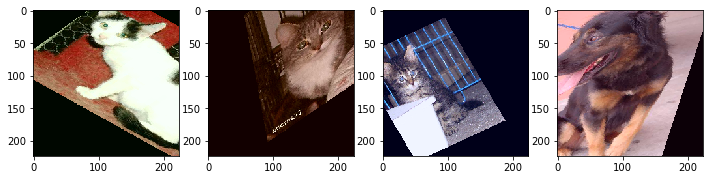

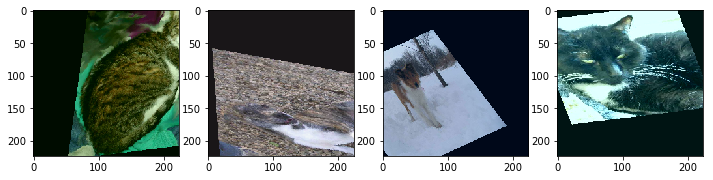

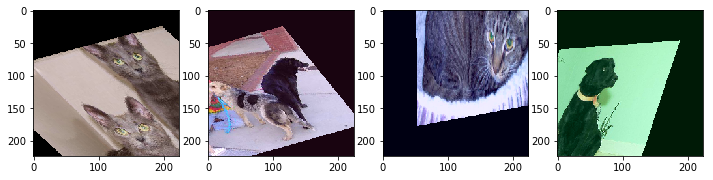

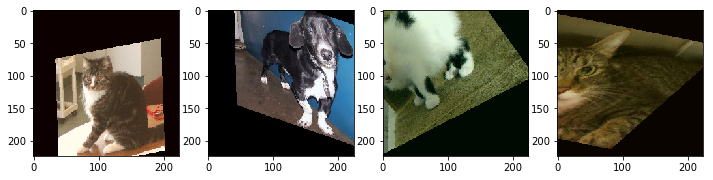

In [19]:
images = next(train)[0]
images.shape
plot_images(images[:16], images_per_row=4)

#### Train the model

In [175]:
model_full.optimizer.lr = 1e-5
samples_per_epoch = train.nb_sample 
model_full.fit_generator(train, samples_per_epoch=samples_per_epoch,
                    nb_epoch=1,
                    validation_data=valid, nb_val_samples=valid.nb_sample,
                    callbacks=[checkpoint])

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.13-64/lock_dir/lock


Epoch 1/1
256/230 [=================================] - 60s - loss: 0.3030 - acc: 0.8711 - val_loss: 0.0515 - val_acc: 0.9800


In [172]:
model_full.save_weights('model_full.hdf5')

## Ensemble models

In [23]:
def train_model(model):
    samples_per_epoch = train.nb_sample 
    
    model.optimizer.lr = 1e-6
    model.fit_generator(train, samples_per_epoch=samples_per_epoch,
                        nb_epoch=1,
                        validation_data=valid, nb_val_samples=valid.nb_sample,
                        callbacks=[])

    model.optimizer.lr = 1e-7
    model.fit_generator(train, samples_per_epoch=samples_per_epoch,
                        nb_epoch=1,
                        validation_data=valid, nb_val_samples=valid.nb_sample,
                        callbacks=[])
    
for index in range(5):
    weights_file = ('2xC64-2xC128-3xC256-6xC512-3xD4096-Drop0.5-BN/'
                    + '23.2-13.50.31-00-0.0445.hdf5')
    fc_weights_file = ('3xD4096-Drop0.5-BN/'
                       + '23.2-16.2.30-00-0.0493.hdf5')
    single_model, _ = create_full_model(weights_file, fc_weights_file,
                                   learning_rate=1e-6)
    train_model(single_model)
    single_model.save_weights('VGG16-Full-Ensemble-{}'.format(index))

    %xdel single_model
    for i in range(3):
        gc.collect()
    
# models = [create_model(dropout=dropout,
#                            learning_rate=1e-5,
#                            weights_file=None) for i in range(5)]
# for index, model in enumerate(models):
#     print('Model {}'.format(index))
#     train_model(model)
#     model.save_weights('VGG16-Ensemble-{}-3x4096-BN-Drop0.3'.format(index))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
23000/23000 [==============================] - 692s - loss: 0.3192 - acc: 0.8986 - val_loss: 0.0576 - val_acc: 0.9820

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
23000/23000 [==============================] - 691s - loss: 0.3192 - acc: 0.9000 - val_loss: 0.0611 - val_acc: 0.9775

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
23000/23000 [==============================] - 689s - loss: 0.3196 - acc: 0.9007 - val_loss: 0.0543 - val_acc: 0.9795

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
23000/23000 [==============================] - 690s - loss: 0.3201 - acc: 0.8986 - val_loss: 0.0563 - val_acc: 0.9810

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_6 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Epoch 1/1
23000/23000 [==============================] - 690s - loss: 0.3300 - acc: 0.8977 - val_loss: 0.0499 - val_acc: 0.9850

## Review Results

In [ ]:
# # Get validation predictions
# valid = get_batch(os.path.join(path, 'valid/'),
#                   batch_size=batch_size * 2,
#                   shuffle=False,
#                   class_mode=None)
# val_results = model.predict_generator(valid, valid.nb_sample)

val_results = model_fast.predict(valid_features, batch_size=1024)

In [ ]:
# cat_prob = val_results[:,0]
probabilities = val_results[:, 1]
filenames = np.array([os.path.join(path, 'valid', filename)
                      for filename in valid_filenames])

classes = valid.classes
results = np.stack([probabilities,
                    filenames,
                    classes])
# How many images can we display at once
max_images = 4

#### Correct labels at random

In [ ]:
corrects = np.where(np.round(probabilities) == classes)[0]
random_correct_indexes = np.random.permutation(corrects)[0:max_images]
plot_files(filenames[random_correct_indexes],
           titles=probabilities[random_correct_indexes])

#### Incorrect labels at random

In [ ]:
# Since they are a small amount we will display them all
incorrects = np.where(np.round(probabilities) != classes)[0]
# random_incorrect_indexes = np.random.permutation(incorrects)[0:max_images]
# display all image in the incorrect index, max_images at a time
plot_files(filenames[incorrects],
           titles=probabilities[incorrects],
           images_per_row=max_images)


#### The most correct labels of each class (high prob and correct)


##### Correct cats

In [ ]:
correct_cat_ids = np.where(
    (np.round(probabilities) == 0))[0]
# Indexes to sort correct)cat_ids
sort_indexes = np.argsort(probabilities[correct_cat_ids])
# Sorted correct
most_correct_cats = correct_cat_ids[sort_indexes]
# Get only a few samples
most_correct_cats = most_correct_cats[0:(max_images * 2)]
plot_files(filenames[most_correct_cats],
           images_per_row=max_images,
           titles=probabilities[most_correct_cats])

##### Correct dogs

In [ ]:
# Get correct dog predictions
correct_dog_ids = np.where(np.round(probabilities) == 1)[0]
# Get ids to sort correct dogs
sort_ids = np.argsort(probabilities[correct_dog_ids])
# Reverse the sort so we get the most correct
sort_ids = sort_ids[::-1]
# Sort correct dog ids
most_correct_dogs = correct_dog_ids[sort_ids]
# Get only the most correct ones
most_correct_dogs = most_correct_dogs[0:max_images * 2]
plot_files(filenames[most_correct_dogs], titles=probabilities[
           most_correct_dogs], images_per_row=max_images)

#### The most incorrect labels of each class (high prob, but incorrect)


##### Incorrect dogs

In [ ]:
# Get indexes where both class is dog and we were off
incorrect_dogs = np.where(
    (classes == 1) & (np.round(probabilities) != classes))[0]
# Returns the indexes that would sort the array
sort_indexes = np.argsort(probabilities[incorrect_dogs])
# Apply the sort indexes to the incorrect dogs indexes
sorted_incorrect_dogs = incorrect_dogs[sort_indexes]
# Select only the most incorrect dogs
sorted_incorrect_dogs = sorted_incorrect_dogs[:max_images * 2]
plot_files(filenames[sorted_incorrect_dogs],
           titles=probabilities[sorted_incorrect_dogs],
           images_per_row=max_images)

##### Incorrect cats

In [ ]:
# Get indexes where both class is cat and we were off
incorrect_cats = np.where(
    (classes == 0) & (np.round(probabilities) != classes))[0]
# Get the indexes that would sort the probabilities array
sort_indexes = np.argsort(probabilities[incorrect_cats])
# Reverse sort indexes, because we want low probabilities, not high
sort_indexes = sort_indexes[::-1]
# Use the sort indexes to sort the incorrect cat indexes
incorrect_cats_sorted = incorrect_cats[sort_indexes]
# Use only the most incorrect cats
incorrect_cats_sorted = incorrect_cats_sorted[:max_images * 2]
plot_files(filenames[incorrect_cats_sorted],
           titles=probabilities[incorrect_cats_sorted],
           images_per_row=max_images)

#### The most uncertian labels (probability close to 0.5)

In [ ]:
# Get distance to 0.5 (most uncertain)
most_uncertain = np.abs(probabilities - 0.5)
# Sort by distance to 0.5 (most uncertain)
sort_indexes = np.argsort(most_uncertain)
# Get only the most uncertain
sort_indexes = sort_indexes[:max_images * 4]
plot_files(filenames[sort_indexes],
           titles=probabilities[sort_indexes],
           images_per_row=max_images)

## Submit results

#### Prepare predictions for test set


##### Ensemble predictions

In [ ]:
all_predictions = [model.predict(test_features, batch_size=batch_size)
                   for model in models]
all_predictions_array = np.asarray(all_predictions)
all_predictions_array.shape
test_predictions = np.mean(all_predictions, axis=0)

##### Single model predictions

In [104]:
# test_predictions = model.predict_generator(test, val_samples=test.nb_sample)
test_predictions = model_fast.predict(test_features, batch_size=batch_size)

In [105]:
# get path to test files
test_filepaths = test_filenames


def filter_test_filepath(filepath):
    '''Utility func to transform 'test/1032.jpg' to 1032
    '''
    filepath = remove_chars_re(filepath, 'test/')
    return int(remove_chars_re(filepath, '.jpg'))
# Format test files as ids
test_ids = [filter_test_filepath(filepath)
            for filepath in test_filepaths]

In [106]:
# Get dog predictions only
dog_predictions = test_predictions[:, 1]

In [107]:
# Trim the predictions, so that we are not penalized for confident mistakes
clip_to = 0.005
predictions_trim = np.clip(dog_predictions, clip_to, 1 - clip_to)

In [108]:
predictions = np.stack([test_ids, predictions_trim], axis=1)

In [109]:
predictions[1:10, 1]

array([ 0.995,  0.005,  0.005,  0.005,  0.995,  0.005,  0.005,  0.005,  0.995])

#### Sanity check the results


In [110]:
# test = get_batch(os.path.join(path, 'test/'),
#                  batch_size=batch_size,
#                  shuffle=False,
#                  class_mode=None)
# test_batch = test.next()
start = 0

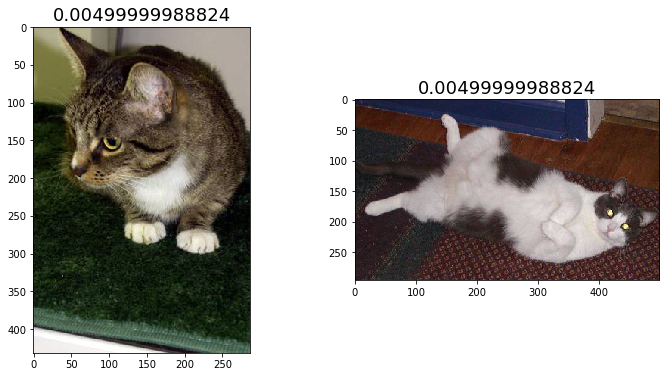

In [111]:
start = start + 2
end = start + 2
full_paths = [os.path.join('test', filename) for filename in test_filenames]
plot_files(full_paths[start:end], titles=predictions[start:end, 1])

#### Export the predictions to csv with Pandas.

In [112]:
import pandas as pd
now = datetime.datetime.now()
date_string = "{0}.{1}-{2}.{3}.{4}".format(
    now.day, now.month, now.hour, now.minute, now.second)
filename = ("cats_dogs-{0}.csv".format(date_string))
header = ['id', 'label']
df = pd.DataFrame(predictions)
# Convert ids (first column) to int
df[0] = df[0].astype(int)
df.to_csv(filename, header=header, index=False)
FileLink(filename)

/home/ubuntu/data/course/cats-dogs/cats_dogs-23.2-16.22.30.csv

#### Submit to kaggle

In [113]:
!kg submit - c 'dogs-vs-cats-redux-kernels-edition' - m "$date_string" $filename